# Optimize noise injection for Flashcam

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8)

import matplotlib.colors as colors

import math

import sys
sys.path.append("..")
import datapipe

import ctapipe
from ctapipe.io.hessio import hessio_event_source
import pyhessio

import scipy.stats

import json

# calibrator
from ctapipe.calib import CameraCalibrator

calib = CameraCalibrator(None, None)

## Read the simtel file and make samples

In [2]:
%%time

tel_id_filter_list = [34, 35, 36, 37, 38]

event_id_filter_list = None

simtel_file = "/Users/jdecock/data/astri_mini_array/gamma/run1001.simtel.gz"

source = hessio_event_source(simtel_file, allowed_tels=tel_id_filter_list)

in_sample_list = []
sig_sample_list = []
noise_sample_list = []
noise2_sample_list = []

for event in source:

    calib.calibrate(event)  # calibrate the event
    event_id = int(event.dl0.event_id)

    if (event_id_filter_list is None) or (event_id in event_id_filter_list):

        for tel_id in event.trig.tels_with_trigger:

            tel_id = int(tel_id)

            if tel_id in tel_id_filter_list:

                # CHECK THE IMAGE GEOMETRY (ASTRI ONLY) ###################

                x, y = event.inst.pixel_pos[tel_id]
                foclen = event.inst.optical_foclen[tel_id]
                geom = ctapipe.instrument.camera.CameraGeometry.guess(x, y, foclen)

                if (geom.pix_type != "hexagonal") or (geom.cam_id not in ("FlashCam",)):
                    raise ValueError("Telescope {}: error (the input image is not a valide Flashcam telescope image)".format(tel_id))

                # GET IMAGES ##############################################
                
                channel = 0

                pe_image = event.mc.tel[tel_id].photo_electron_image
                
                uncalibrated_image = event.r0.tel[tel_id].adc_sums[channel]
                
                #pedestal = event.mc.tel[tel_id].pedestal[channel]
                #gain = event.mc.tel[tel_id].dc_to_pe[channel]
                #pixel_pos = event.inst.pixel_pos[tel_id]

                ## Mix channels (not done in ctapipe because cameras will do it automatically in production, there will be only 1 channel then ; i.e. this issue only concerns simulations)
                ## Taken from TinoCTA ./modules/prepare_event.py l.77
                #pmt_signal = event.dl1.tel[tel_id].image
                #if pmt_signal.ndim > 1 and pmt_signal.shape[0] > 1:
                #    pick = (pmt_signal > 14).any(axis=0) != np_true_false
                #    pmt_signal = pmt_signal.T[pick.T]
                #else:
                #    pmt_signal = pmt_signal.ravel()

                calibrated_image = event.dl1.tel[tel_id].image[channel]
                
                
                in_sample_list.append(calibrated_image)
                sig_sample_list.append(pe_image)
                noise_sample_list.append(calibrated_image - pe_image)
                noise2_sample_list.extend(calibrated_image[pe_image == 0.].tolist())

CPU times: user 8min 56s, sys: 5.53 s, total: 9min 2s
Wall time: 9min 15s


In [3]:
in_sample_array = np.array(in_sample_list).ravel()
sig_sample_array = np.array(sig_sample_list).ravel()
noise_sample_array = np.array(noise_sample_list).ravel()
noise2_sample_array = np.array(noise2_sample_list)

## Save samples (for further use)

In [4]:
#data = {}

#data["in_sample"] = in_sample_array.tolist()
#data["sig_sample"] = sig_sample_array.tolist()
#data["noise_sample"] = noise_sample_array.tolist()
#data["noise2_sample"] = noise2_sample_list

#with open("../astri_hist.json", "w") as fd:
#    json.dump(data, fd, sort_keys=False, indent=1)

## Plot samples

### Calibrated input image (signal + noise)

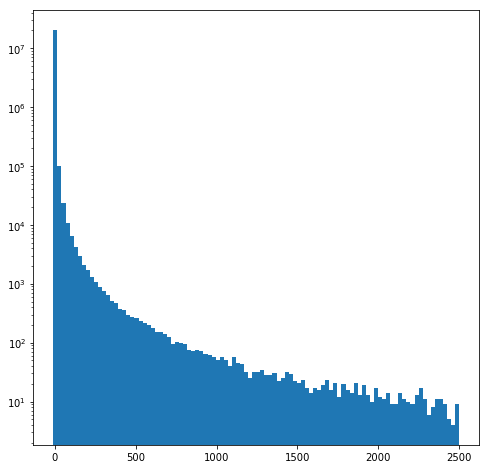

In [5]:
plt.hist(in_sample_array,
         bins=100,
         range=(-10, 2500),
         log=True);

### Signal

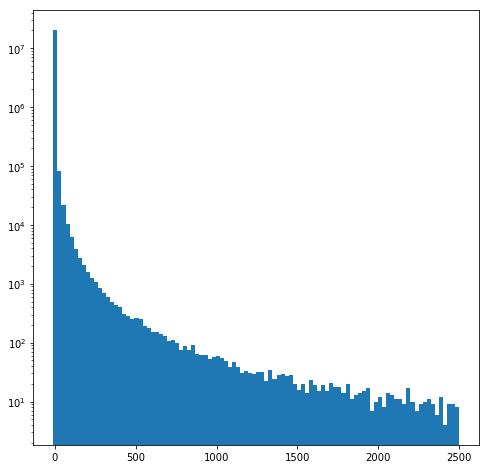

In [6]:
plt.hist(sig_sample_array,
         bins=100,
         range=(-10, 2500),
         log=True);

### Noise version 1: input - signal

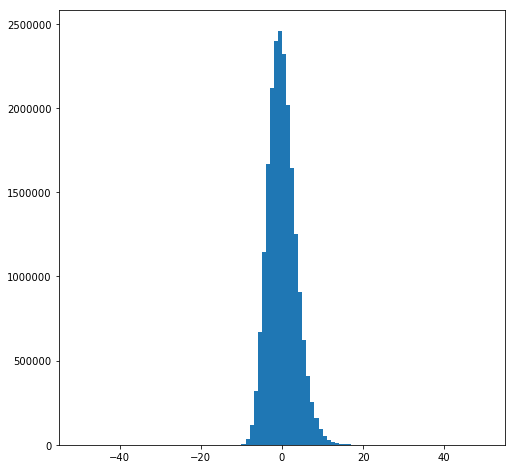

In [7]:
plt.hist(noise_sample_array,
         bins=100,
         range=(-50, 50),    # the actual range is larger than that because of outliers...
         log=False);

### Noise version 2: input where signal = 0

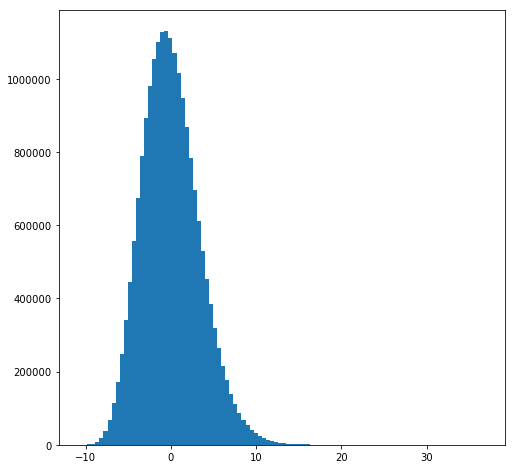

In [8]:
plt.hist(noise2_sample_array,
         bins=100,
         range=(noise2_sample_array.min(), noise2_sample_array.max()),
         log=False);

In [9]:
print("min:", noise2_sample_array.min())
print("max:", noise2_sample_array.max())
print("mean:", noise2_sample_array.mean())
print("std:", noise2_sample_array.std())

min: -10.7659183817
max: 36.8351427354
mean: 0.0206598559692
std: 3.38243862231


## Compute the $\chi^2$: an example with a given model using scipy

Sample min value: 0
Sample max value: 36
x_h: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]
bins: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
y_h: [  2.68591519e+06   5.37183038e+06   5.37183038e+06   3.58122025e+06
   1.79061013e+06   7.16244050e+05   2.38748017e+05   6.82137191e+04
   1.70534298e+04   3.78965106e+03   7.57930212e+02   1.37805493e+02
   2.29675822e+01   3.53347418e+00   5.04782026e-01   6.73042701e-02
   8.41303376e-03   9.89768678e-04   1.09974298e-04   1.15762418e-05
   1.15762418e-06   1.10249922e-07   1.00227202e-08   8.71540888e-10
   7.26284074e-11   5.81027259e-12   4.46944045e-13   3.31069663e-14
   2.36478331e-15   1.63088504e-16   1.08725669e-17   7.01455931e-19
   4.38409957e-20   2.65703004e-21   1.56295885e-22   8.93119342e-24
   4.96177412e-25]
y_e: [2230957 1942698 1577621 1204392  867971  595192  388918  242500  1

2.022561393031367e+24

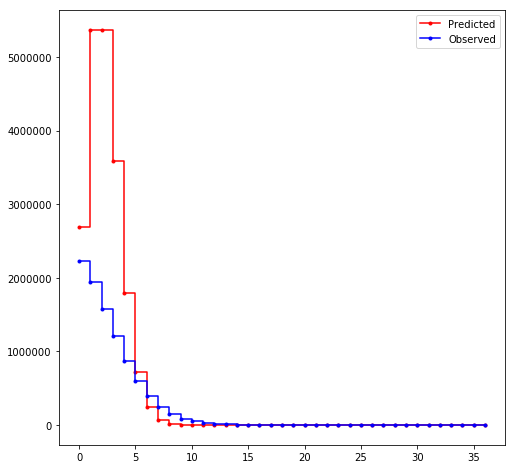

In [10]:
data = noise2_sample_array

def dist_chi2(k, *param):
    
    min_value = 0 # math.floor(data.min())   # TODO !
    max_value = math.floor(data.max())
    
    x_h = np.arange(min_value, max_value+1, 1)
    
    print("Sample min value:", min_value)
    print("Sample max value:", max_value)
    
    # Predicted values ################
    
    dist = scipy.stats.poisson(k)
    y_h = dist.pmf(x_h) * len(data)

    # Observed values #################
    
    bins = np.concatenate([x_h, np.array([x_h[-1] + 1])])
    y_e, _bins = np.histogram(data, bins=bins) #, normed=True)

    # https://github.com/numpy/numpy/issues/1894
    #np.bincount(np.array([3, 4, 3, 5, 4, 3, 3, 3, 4]))  # only works with positive values
    #y_e = np.bincount(data)
    
    # Compute the Chi2 ################

    dist = scipy.stats.chisquare(y_e, y_h)
    chi2 = dist.statistic
    
    # Plot ############################
    
    print("x_h:", x_h)
    print("bins:", bins)
    print("y_h:", y_h)
    print("y_e:", y_e)
    
    plt.step(x_h, y_h, 'r.', where='post', label="Predicted")
    plt.step(x_h, y_e, 'b.', where='post', label="Observed")
    plt.legend()

    return chi2

dist_chi2(2.)

## Compute the $\chi^2$: another example approximating the PDF's model empirically

In [11]:
%%time

data = noise2_sample_array

min_value = -10  # math.floor(data.min())   # TODO if Gaussian not used
max_value =  15  # math.floor(data.max())   # TODO !!

x_h = np.arange(min_value, max_value+1, 1)

#print("Sample min value:", min_value)
#print("Sample max value:", max_value)

bins = np.concatenate([x_h, np.array([x_h[-1] + 1])])

# Observed values #################

y_e, _bins = np.histogram(data, bins=bins, normed=False)

# https://github.com/numpy/numpy/issues/1894
#np.bincount(np.array([3, 4, 3, 5, 4, 3, 3, 3, 4]))  # only works with positive values
#y_e = np.bincount(data)

CPU times: user 1.56 s, sys: 2.31 ms, total: 1.56 s
Wall time: 1.56 s


In [12]:
def dist_chi2(x, verbose=False, plot=False, very_verbose=False):
    k, mu, sigma = x
    
    try:
        # Predicted values ################

        size = 1000000
        
        data_h = np.zeros(size)
        if (k is not None) and (k > 0):
            data_h += np.random.poisson(lam=k, size=size).astype('float64')
        if (mu is not None) and (sigma is not None) and (sigma > 0):
            data_h += np.random.normal(loc=mu, scale=sigma, size=size)

        y_h, _bins = np.histogram(data_h, bins=bins, normed=False)

        y_h = y_h * len(data) / size

        # Compute the Chi2 ################

        dist = scipy.stats.chisquare(y_e, y_h)
        chi2 = dist.statistic

        # Plot ############################

        if very_verbose:
            print("x_h:", x_h)
            print("bins:", bins)
            print("y_h:", y_h)
            print("y_e:", y_e)
            
        if plot:
            plt.step(x_h, y_h, 'r.', where='post', label="Predicted")
            plt.step(x_h, y_e, 'b.', where='post', label="Observed")
            plt.legend()
    except Exception as e:
        print(x, e)
        #chi2 = 1.
        #chi2 = np.nan     # would "inf" be better ?
        chi2 = np.inf
    
    if verbose:
        print(">", x, chi2)

    return chi2

In [13]:
%%time

# Test the above function
x = (1.9, 0.5, 0.8)
print("Chi2=", dist_chi2(x))

Chi2= inf
CPU times: user 207 ms, sys: 12.6 ms, total: 219 ms
Wall time: 270 ms


/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


## Optimize the $\chi^2$ with scipy (using the "brute force" optimizer)

In [14]:
%%time

from scipy import optimize

k_slice = slice(0, 6, 0.1)
mu_slice = slice(-8, 8, 0.1)
sigma_slice = slice(0, 6, 0.1)

search_ranges = (k_slice, mu_slice, sigma_slice)
#search_ranges = (p_slice, )

res = optimize.brute(dist_chi2,
                     search_ranges,
                     #args=(True, False, False),
                     full_output=True,
                     finish=None)     #optimize.fmin)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


CPU times: user 1d 8h 52min 33s, sys: 30min 36s, total: 1d 9h 23min 10s
Wall time: 1d 9h 23min 6s


## And the (nearly) optimal model is...

In [15]:
print("x* =", res[0])
print("f(x*) =", res[1])

x* = [ 5.9 -5.9  2.4]
f(x*) = 268715.148596


## Plot $\chi^2$ over iterations (just to have a rough idea of what happened)

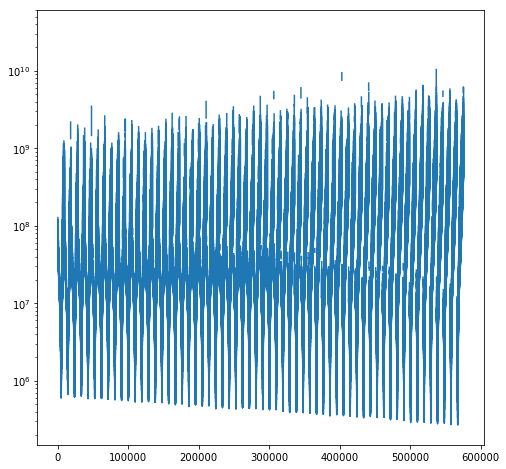

In [16]:
plt.semilogy(res[3].ravel(), )

## Plot the solution space (3D space projected on several 2D spaces)

In [17]:
res[2].shape

(3, 60, 160, 60)

In [18]:
res[3].shape

(60, 160, 60)

In [19]:
best_index = np.unravel_index(res[3].argmin(), res[3].shape)
best_index

(59, 21, 24)

In [20]:
res[3][best_index]

268715.1485958987

In [21]:
k_best_index = np.unravel_index(res[3].argmin(), res[3].shape)[0]

def plot_projection(k_index):
    fig, ax = plt.subplots(figsize=(6, 6))

    xx = res[2][1][k_index, :, :]
    yy = res[2][2][k_index, :, :]

    zz = res[3][k_index, :, :]

    min_value = res[3][best_index]
    max_value = min_value*10000
    
    levels = np.array([10.*min_value,
                       100.*min_value,
                       500.*min_value,
                       1000.*min_value])

    im = ax.pcolormesh(xx, yy, zz,
                       vmin=min_value,
                       vmax=max_value,
                       norm=colors.LogNorm(),
                       cmap='gnuplot2')

    plt.colorbar(im, ax=ax)

    cs = plt.contour(xx, yy, zz, levels,
                     linewidths=(2, 2, 2, 3),
                     linestyles=('dotted', 'dashed', 'solid', 'solid'),
                     alpha=0.5,
                     colors='blue')
    ax.clabel(cs, inline=False, fontsize=12)

    # PLOT ########################################################################

    ax.scatter(res[0][1],
               res[0][2],
               c='red',
               label="$x^*$")
    
    #print(res[2][0][k_index, :, :])
    ax.set_title("k = {} ({})".format(res[2][0][k_index, 0, 0], k_index))
        
    ax.set_xlabel("mu")
    ax.set_ylabel("sigma")

    ax.legend(fontsize=12)
    

    plt.show()

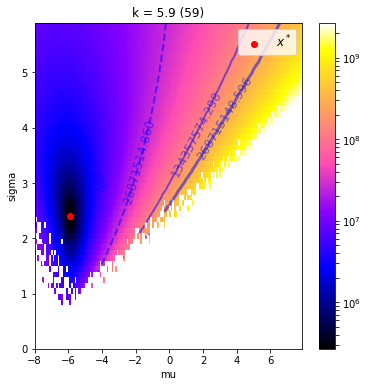

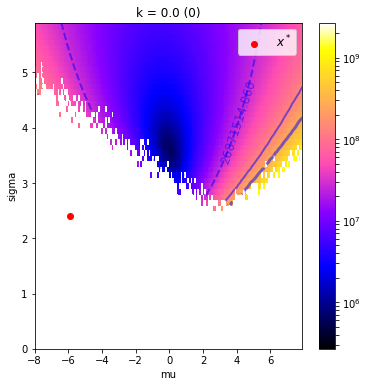

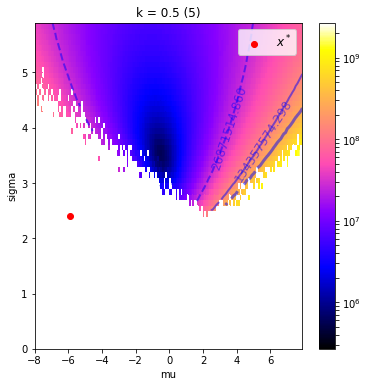

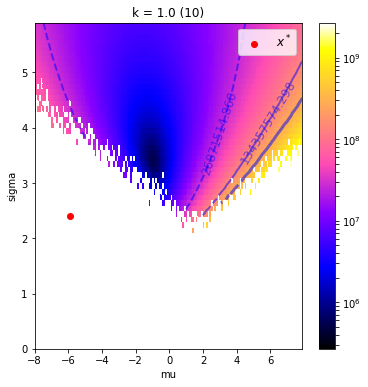

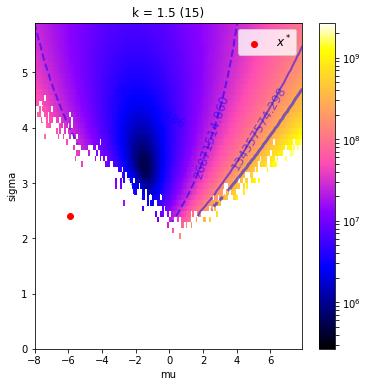

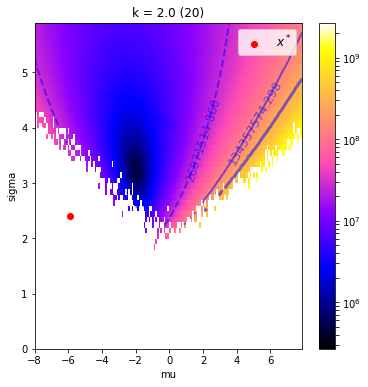

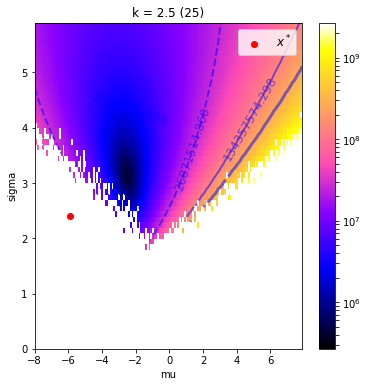

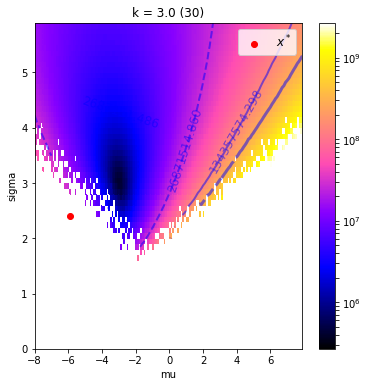

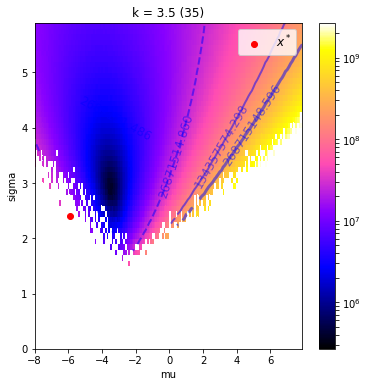

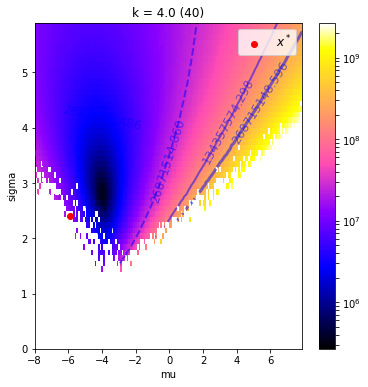

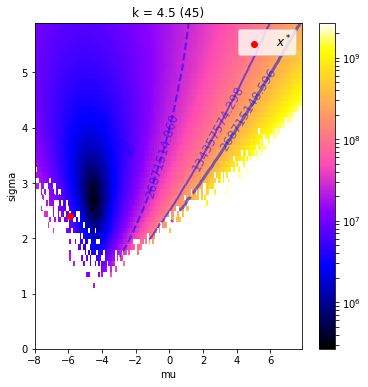

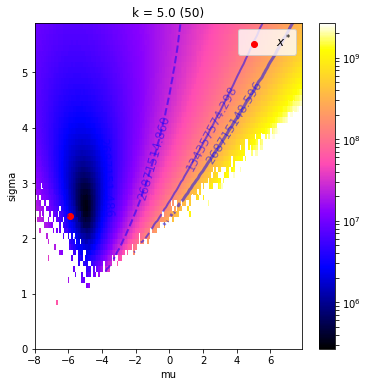

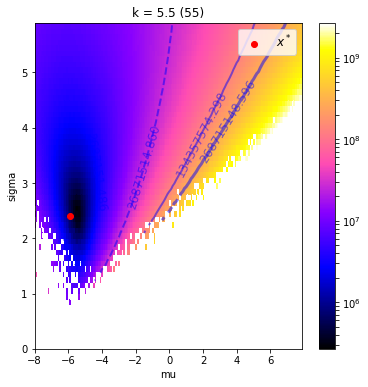

In [22]:
plot_projection(k_best_index)

for k_index in range(0, res[3].shape[0], 5):
    plot_projection(k_index)

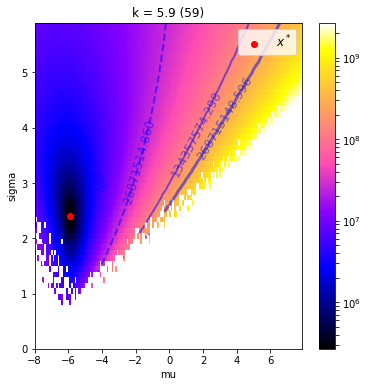

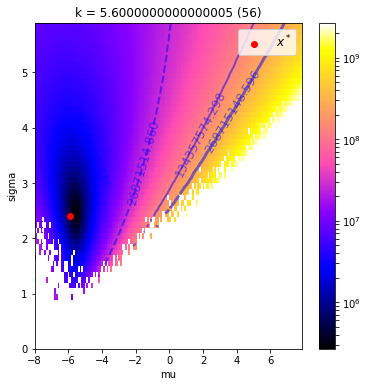

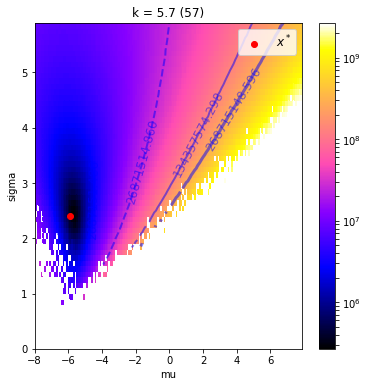

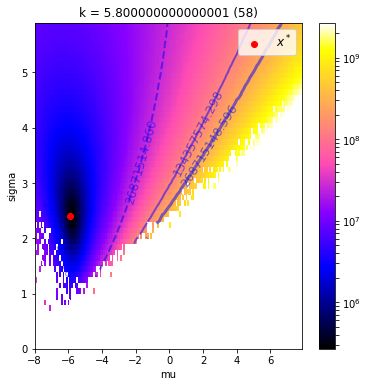

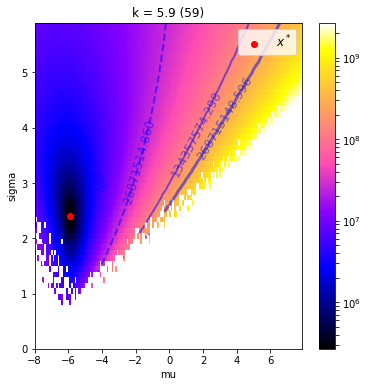

In [23]:
plot_projection(k_best_index)

for k_index in range(max(k_best_index - 3, 0),
                     min(k_best_index + 4, res[3].shape[0])):
    plot_projection(k_index)

## Plot observed vs predicted with the optimal parameter found

287937.63849523751

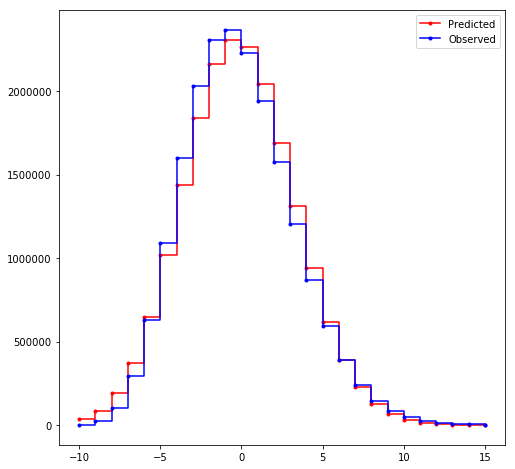

In [24]:
dist_chi2(res[0], plot=True)

## The former optimal parameter found with fmin was...

x* = [ 1.98064017  0.42485775  0.77274323]
f(x*) = 25645.10163
CPU times: user 30min 56s, sys: 8.58 s, total: 31min 5s
Wall time: 31min 13s

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


inf

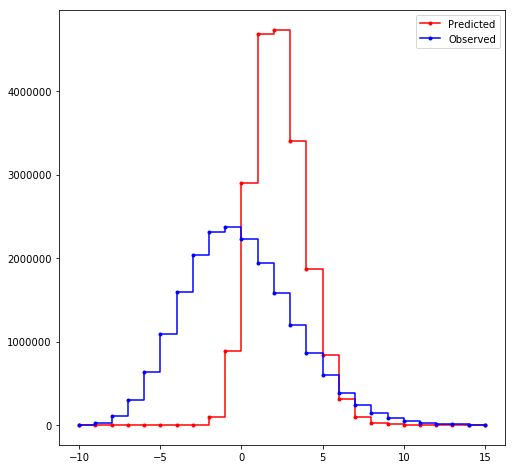

In [25]:
dist_chi2([ 1.98064017, 0.42485775, 0.77274323], plot=True)

## Plot observed vs predicted with my former parameter found "by hand"

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


inf

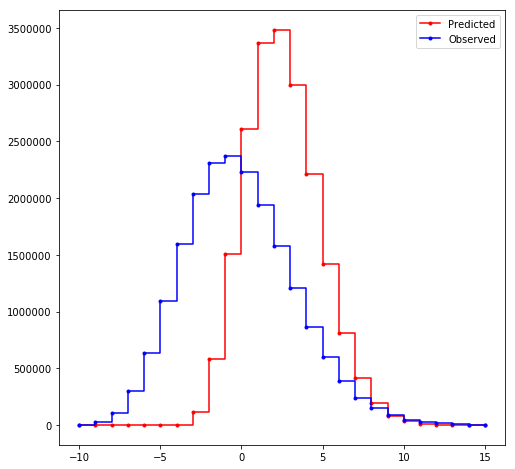

In [26]:
# This is the parameters I choosed by hand

INJECT_NOISE_IN_NAN_LAMBDA = 5
INJECT_NOISE_IN_NAN_MU = -2.1
INJECT_NOISE_IN_NAN_SIGMA = 0.1

x = (INJECT_NOISE_IN_NAN_LAMBDA, INJECT_NOISE_IN_NAN_MU, INJECT_NOISE_IN_NAN_SIGMA)
dist_chi2(x, plot=True)

## Plot observed vs predicted with Tino's former parameter found "by hand"

6118942.62221161

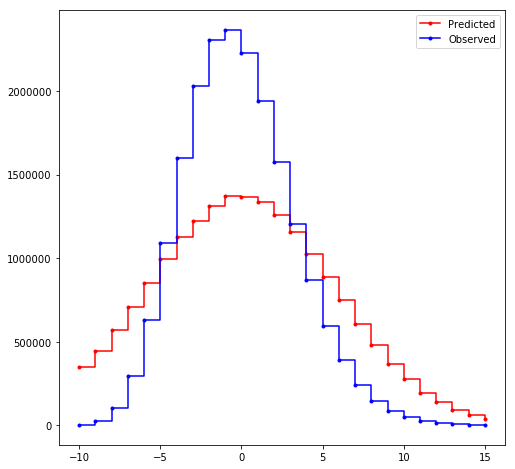

In [27]:
# This is the parameters I choosed by hand

INJECT_NOISE_IN_NAN_MU = 0.13
INJECT_NOISE_IN_NAN_SIGMA = 5.77

x = (None, INJECT_NOISE_IN_NAN_MU, INJECT_NOISE_IN_NAN_SIGMA)
dist_chi2(x, plot=True)